# ECG Beat Detector Comparison
## Important Variables
Important variables used throughout the code can be changed here.
- `segmentation_window_size`: every signal in a database is sliced into pieces of `segmentation_window_size` seconds to make the signals more comparable
- `tolerance_window_size`: to determine wether a QRS complex was determined correctly a tolerance window of ±`tolerance_window_size` milliseconds is used

In [1]:
segmentation_window_size = 10 # in seconds, default is 10
tolerance_window_size = 150 # in milliseconds, default is 150

## Import Libraries & Start Engines
Install all important libraries with pip apart from `matlab.engine` which has to be installed from the MATLAB root folder. You can find more information on instlaling the `matlab.engine` [here](https://de.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [2]:
import matlab.engine
import numpy as np
from cProfile import label
import matplotlib.pyplot as plt
%matplotlib widget
import pathlib
from ecgdetectors import Detectors
import sys
import wfdb
from wfdb import processing
import pandas
import os
from detectors.visgraphdetector import VisGraphDetector

Start the `matlab.engine` to be able to execute MATLAB commands or functions from within Python.

In [3]:
eng = matlab.engine.start_matlab()

## Generate Synthetic Signal
Some initial parameters for the generation of the synthetic signals. Here it is possible to choose diffent types of artificial noise and also choose whether the signal should be real or synthetic.

In [4]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 4       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1       # 1 - real RR series are used, 0 - synthetic
realVAon = 1       # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1       # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

In the next field the signal is generated.

In [5]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path, nargout=0)

returndata = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

## Define Classes
The necessary classes for the detectors and the databases are created.

In [6]:
class Detector():
    def __init__(self, name, short_name, algorithm) -> None:
        self.name = name
        self.algorithm = algorithm
        self.short_name = short_name
    
    def predicted_qrs_compelx(self, signal, fs):
        return self.algorithm(signal, fs)

    def name(self):
        return self.name

    def short_name(self):
        return self.short_name

class Database():
    def __init__(self, name, signal, actual_qrs_complex, fs) -> None:
        self.name = name
        self.signal = signal
        self.actual_qrs_complex = actual_qrs_complex
        self.fs = fs
    
    def signal(self):
        return self.signal

    def actual_qrs_complex(self):
        return self.actual_qrs_complex

    def fs(self):
        return self.fs

class Evaluation():
    def __init__(self, Database) -> None:
        self.Database = Database

Create arrays to safe the detectors and databases.

In [7]:
detectors = []
databases = []

## Add Databases
Create `Database` objects which can later be added to `databases`.

In [8]:
telehealth_fs = 500
telehealth_act=[]
telehealth_data=pandas.read_csv("C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Databases/1_1.dat",sep=",",header=None) #248_296 is good
telehealth_signal = np.array(telehealth_data[0]).astype(float)
for i in range(len(telehealth_data[1])):
    if telehealth_data[1][i]:
        telehealth_act.append(i)

telehealth_act = np.array(telehealth_act).astype(int)

In [9]:
signals = []
telehealth_act_arrays = []

for i in range((len(telehealth_signal)//(telehealth_fs*segmentation_window_size)*2)-1):
    
    min_index = i*(telehealth_fs*segmentation_window_size//2)
    max_index = i*(telehealth_fs*segmentation_window_size//2)+telehealth_fs*segmentation_window_size-1

    signals.append(telehealth_signal[min_index:max_index])

    min_count = 0
    max_count = 0

    for j in range(len(telehealth_act)):
        if telehealth_act[j] < min_index:
            min_count += 1
        if telehealth_act[j] < max_index:
            max_count += 1
    telehealth_act_arrays.append(telehealth_act[min_count:max_count])
    

print(len(telehealth_signal))
for i in range(len(signals)):
    print(len(signals[i]))

print(telehealth_act_arrays)


15797
4999
4999
4999
4999
4999
[array([3731, 4206, 4682]), array([3731, 4206, 4682, 5174, 5688, 6197, 6704, 7224]), array([5174, 5688, 6197, 6704, 7224, 7753, 8282, 8806, 9346, 9892]), array([ 7753,  8282,  8806,  9346,  9892, 10435, 10971, 11501, 12002]), array([10435, 10971, 11501, 12002, 12507, 13021, 13522, 14024, 14526])]


In [10]:
synth_database = Database(
    name="Synthetic data", 
    signal=np.transpose(np.array(returndata['multileadECG']))[:,0], 
    actual_qrs_complex=np.transpose(np.array(returndata['QRSindex']))[:,0].astype(int), 
    fs=500)

wfdb_test_database = Database(
    name="WFDB Test Database",
    signal=np.array(wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).p_signal[:,0]),
    actual_qrs_complex=np.array(wfdb.rdann('sample-data/100','atr', sampfrom=0, sampto=10000).sample[1:]).astype(int),
    fs=wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).fs)

telehealth_environment_test_database = Database(
    name="Telehealth Test Database",
    signal=telehealth_signal,
    actual_qrs_complex=telehealth_act,
    fs=500)

Add data from different databases to `databases`.

In [11]:
# databases.append(synth_database)
databases.append(wfdb_test_database)
#databases.append(telehealth_environment_test_database)

## Add Detectors
Add detectors from different locations in the standaradized format to the detectors list.

Add gqrs detector to the detectors list in the standard format.

In [12]:
detectors.append(Detector(name="GQRS", short_name="gqrs", algorithm=processing.qrs.gqrs_detect))

Create function and add jqrs detector to the detectors list in the standard format.

In [13]:
jqrs_algo_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\MATLAB\jqrs\sources')
eng.addpath(jqrs_algo_path, nargout=0)

def run_jqrs_detector(signal, fs):
    return np.array(eng.qrs_detect2(matlab.double(signal), 0.6, 0.25, matlab.double(fs)))[0].astype(int)

detectors.append(Detector(name="JQRS", short_name="jqrs", algorithm=run_jqrs_detector))

Create function and add visgraphdetector detector to the detectors list in the standard format.

In [14]:
beta = 0.55
gamma = 0.5
lowcut = 4

def run_visgraph_detector(signal, fs):
    R_peaks, weights, weighted_signal = VisGraphDetector(fs).visgraphdetect(signal, beta=beta, gamma=gamma, lowcut=lowcut, M = 2*fs)
    return R_peaks

detectors.append(Detector(name="VisGraphDetector", short_name="visgraph", algorithm=run_visgraph_detector))

Create function and add rpeakdetect detector to the detectors list in the standard format.

In [15]:
rpeakdetect_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Playground\detectors')
eng.addpath(rpeakdetect_path, nargout=0)

def run_rpeakdetect_detector(signal, fs):
    threshhold = 0.2 # default = 0.2
    testmode = 0 # default = 0
    newsignal = [[i] for i in signal]
    return np.array(eng.rpeakdetect(matlab.double(newsignal), matlab.double(fs),threshhold,testmode)['R_index'])[0].astype(int)

detectors.append(Detector(name="rpeakdetect", short_name="rpeak", algorithm=run_rpeakdetect_detector))

In [16]:
#r_deco_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code/MATLAB/r-deco/R_peak_detection')
from operator import invert
from pdb import post_mortem


r_deco_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Playground\detectors/r_deco')
eng.addpath(r_deco_path, nargout=0)

def run_r_deco_detector(signal, fs):
    envelope_size = 300.0 # envelope size in ms, default = 300.0
    average_heart_rate = 100.0 # average heart rate in bpm, default = 100.0
    post_processing = 1.0 # post processing where 1.0 means yes, default = 1.0
    ectopic_removal = 0.0 # ectopic removal where 1.0 means yes, default = 0.0
    inverted_signal = 0.0 # inverted signal where 1.0 means yes, default = 0.0
    parameters_check = 0.0 # parameters check in UI where 1.0 means yes, default = 0.0
    newsignal = [[i] for i in signal]
    return np.array(eng.peak_detection([envelope_size,average_heart_rate,post_processing,ectopic_removal,inverted_signal],matlab.double(newsignal), matlab.double(fs),parameters_check)).astype(int)[0][0]

detectors.append(Detector(name="r_deco", short_name="rdeco", algorithm=run_r_deco_detector))

Create functions to get the detectors from the `ecgdetectors` package into the right standard format to be able to iterate through them.

In [17]:
def run_two_average_detector(signal, fs):
    return Detectors(fs).two_average_detector(unfiltered_ecg=signal)

def run_matched_filter_detector(signal, fs):
        return Detectors(fs).matched_filter_detector(unfiltered_ecg=signal)

def run_swt_detector(signal, fs):
    return Detectors(fs).swt_detector(unfiltered_ecg=signal)

def run_engzee_detector(signal, fs):
    return Detectors(fs).engzee_detector(unfiltered_ecg=signal)

def run_christov_detector(signal, fs):
    return Detectors(fs).christov_detector(unfiltered_ecg=signal)

def run_hamilton_detector(signal, fs):
    return Detectors(fs).hamilton_detector(unfiltered_ecg=signal)

def run_pan_tompkins_detector(signal, fs):
    return Detectors(fs).pan_tompkins_detector(unfiltered_ecg=signal)

def run_wqrs_detector(signal, fs):
    return Detectors(fs).wqrs_detector(unfiltered_ecg=signal)

Add detectors from the `ecgdetectors` package to the detectors list.

In [18]:
detectors.append(Detector(name="Elgendi et al (Two average)", short_name="two_avg", algorithm=run_two_average_detector))
detectors.append(Detector(name="Matched filter", short_name="match_fil", algorithm=run_matched_filter_detector))
detectors.append(Detector(name="Kalidas & Tamil (Wavelet transform)", short_name="swt", algorithm=run_swt_detector))
detectors.append(Detector(name="Engzee", short_name="engz", algorithm=run_engzee_detector))
detectors.append(Detector(name="Christov", short_name="christ", algorithm=run_christov_detector))
detectors.append(Detector(name="Hamilton", short_name="hamilt", algorithm=run_hamilton_detector))
detectors.append(Detector(name="Pan Tompkins", short_name="pan_tomp", algorithm=run_pan_tompkins_detector))
detectors.append(Detector(name="WQRS", short_name="wqrs", algorithm=run_wqrs_detector))

## Predict QRS Complexes
All algorithms are run and the resulting QRS complexes are saved in vectors.

In [19]:
from shutil import ExecError


predictedpeaks = []
for i in range(len(detectors)):
    if detectors[i].short_name == "match_fil" and (databases[0].fs != 250 and databases[0].fs != 360):
        print(detectors[i].short_name, "could not run because the sample rate is wrong and was skipped")
        predictedpeaks.append([])
        continue

    try:
        predictedpeaks_per_algo = detectors[i].predicted_qrs_compelx(signal=databases[0].signal, fs=databases[0].fs)
    except IndexError:
        print(detectors[i].short_name, "failed due to an index error and was skipped")
        predictedpeaks.append([])
        continue
    
    predictedpeaks.append(predictedpeaks_per_algo)

Display the respective graphs for each database including each algorithm.

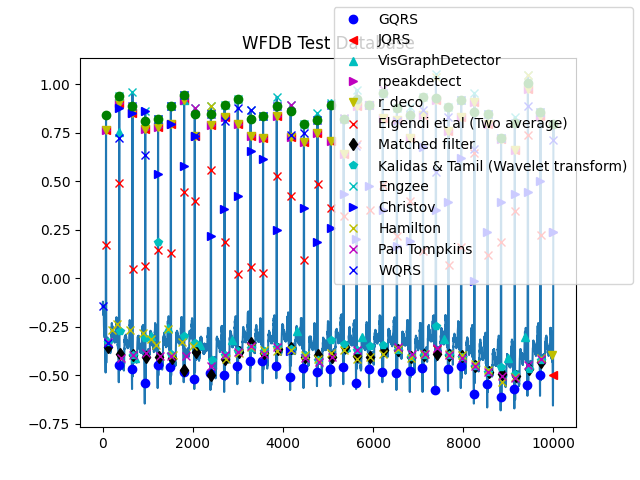

In [20]:
fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>','yx','mx','bx']

if(len(databases) != 1):

    fig, ax = plt.subplots(len(databases))

    for dbcnt in range(len(databases)):
        ax[dbcnt].plot(databases[dbcnt].signal)

        for ppcnt in range(len(predictedpeaks)):
            ax[dbcnt].plot(predictedpeaks[ppcnt], databases[dbcnt].signal[predictedpeaks[ppcnt]], fmt[ppcnt],label=detectors[ppcnt].name)
        ax[dbcnt].plot(databases[dbcnt].actual_qrs_complex, databases[dbcnt].signal[databases[dbcnt].actual_qrs_complex], 'go')
        ax[dbcnt].set_title(databases[dbcnt].name)

    fig.legend()

else:
    dbcnt = 0
    fig, ax = plt.subplots(len(databases))

    for dbcnt in range(len(databases)):
        ax.plot(databases[dbcnt].signal)

        for ppcnt in range(len(predictedpeaks)):
            ax.plot(predictedpeaks[ppcnt], databases[dbcnt].signal[predictedpeaks[ppcnt]], fmt[ppcnt],label=detectors[ppcnt].name)
        ax.plot(databases[dbcnt].actual_qrs_complex, databases[dbcnt].signal[databases[dbcnt].actual_qrs_complex], 'go')
        ax.set_title(databases[dbcnt].name)

    fig.legend()

## Calculate Binary Classification 
Calculate true-positive, false-positive, and false-negative rate for each detector and database and display them.

In [21]:
pp = [len(predictedpeaksperalg) for predictedpeaksperalg in predictedpeaks]
tp = np.zeros(len(detectors), dtype=int)
fp = np.zeros(len(detectors), dtype=int)
fn = np.zeros(len(detectors), dtype=int)

for j in range(len(predictedpeaks)):

    actualpeaksiter = databases[0].actual_qrs_complex

    for predictedpeak in predictedpeaks[j]:
        tpdetect = 1
        for i in range(len(actualpeaksiter)):
            if predictedpeak >= (actualpeaksiter[i] - tolerance_window_size) and predictedpeak <= (actualpeaksiter[i] + tolerance_window_size):
                tp[j]+=1
                tpdetect = 0
                actualpeaksiter = np.delete(actualpeaksiter, i)
                break
        if tpdetect:
            fp[j]+=1

    for actualpeak in actualpeaksiter:
        fn[j]+=1

data = [pp,tp,fp,fn]
rows = ["pred peak", "true pos", "false pos", "false neg"]
columns = [detector.short_name for detector in detectors]

print("actual peaks = ", len(databases[0].actual_qrs_complex))
print(pandas.DataFrame(data, rows, columns))

actual peaks =  35
           gqrs  jqrs  visgraph  rpeak  rdeco  two_avg  match_fil  swt  engz  \
pred peak    33    35        14     35     35       34         34   34    33   
true pos     33    35        14     35     35       34         34   34    33   
false pos     0     0         0      0      0        0          0    0     0   
false neg     2     0        21      0      0        1          1    1     2   

           christ  hamilt  pan_tomp  wqrs  
pred peak      34      36        34    36  
true pos       34      34        34    35  
false pos       0       2         0     1  
false neg       1       1         1     0  


## Calculate f1-score
Calculate the f1-score the sensitivity and the positive predictivity and display them for each detector and each database.

In [22]:
sensitivity = tp / (tp+fn)
positive_predictivity = tp / (tp+fp)
f1_score = tp / (tp+.5*(fp+fn))

data = [np.around(sensitivity,decimals=2), np.around(positive_predictivity,decimals=2),np.around(f1_score,decimals=2)]
rows = ["sensitiv", "pos pred", "f1 score"]
columns = [detector.short_name for detector in detectors]

print(pandas.DataFrame(data, rows, columns))

          gqrs  jqrs  visgraph  rpeak  rdeco  two_avg  match_fil   swt  engz  \
sensitiv  0.94   1.0      0.40    1.0    1.0     0.97       0.97  0.97  0.94   
pos pred  1.00   1.0      1.00    1.0    1.0     1.00       1.00  1.00  1.00   
f1 score  0.97   1.0      0.57    1.0    1.0     0.99       0.99  0.99  0.97   

          christ  hamilt  pan_tomp  wqrs  
sensitiv    0.97    0.97      0.97  1.00  
pos pred    1.00    0.94      1.00  0.97  
f1 score    0.99    0.96      0.99  0.99  
